In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import scipy.optimize as spo

In [4]:
# ----------- convenciones ------------------
dias_mes=30
dia_año=360
dia_prestamo=365
#================== caracteristicas de los contratos en días ===================

plazos_tasas=[3*dias_mes,6*dias_mes,12*dias_mes,2*dia_año,3*dia_año,5*dia_año,7*dia_año,10*dia_año]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

# Abrir datos

In [5]:
datos=pd.read_excel("datos_taller.xlsx", index_col=0)/100

In [6]:
datos.tail()

,ICE LIBOR USD 3 Month,ICE LIBOR USD 6 Month,ICE LIBOR USD 12 Month,USD SWAP SEMI 30/360 2YR,USD SWAP SEMI 30/360 3YR,USD SWAP SEMI 30/360 5YR,USD SWAP SEMI 30/360 7YR,USD SWAP SEMI 30/360 10Y
Dates,,,,,,,,
2020-02-06,0.017341,0.017496,0.018426,0.015046,0.014624,0.014704,0.015168,0.016031
2020-02-07,0.017309,0.017404,0.018349,0.014552,0.014089,0.014129,0.014561,0.015400
2020-02-10,0.017131,0.017206,0.018005,0.014313,0.013850,0.013891,0.014329,0.015169
2020-02-11,0.017073,0.017245,0.018071,0.014561,0.014129,0.014172,0.014630,0.015473
2020-02-12,0.017037,0.017254,0.018127,0.014890,0.014509,0.014585,0.015051,0.015894


Asignar a cada prestamo los dias de duración

In [7]:
plazos={}
for i in range(len(datos.columns)):
    plazos[datos.columns[i]]=plazos_tasas[i]
plazos

{'ICE LIBOR USD 3 Month': 90,
 'ICE LIBOR USD 6 Month': 180,
 'ICE LIBOR USD 12 Month': 360,
 'USD SWAP SEMI 30/360 2YR': 720,
 'USD SWAP SEMI 30/360 3YR': 1080,
 'USD SWAP SEMI 30/360 5YR': 1800,
 'USD SWAP SEMI 30/360 7YR': 2520,
 'USD SWAP SEMI 30/360 10Y': 3600}

In [8]:
tipo={}
instrumento=["libor","libor","libor","swap","swap","swap","swap","swap"]
for i in range(len(datos.columns)):
    tipo[i]=instrumento[i]
tipo

{0: 'libor',
 1: 'libor',
 2: 'libor',
 3: 'swap',
 4: 'swap',
 5: 'swap',
 6: 'swap',
 7: 'swap'}

In [9]:
nombre={}
for i in range(len(datos.columns)):
    nombre[i]=datos.columns[i]
nombre

{0: 'ICE LIBOR USD 3 Month',
 1: 'ICE LIBOR USD 6 Month',
 2: 'ICE LIBOR USD 12 Month',
 3: 'USD SWAP SEMI 30/360 2YR',
 4: 'USD SWAP SEMI 30/360 3YR',
 5: 'USD SWAP SEMI 30/360 5YR',
 6: 'USD SWAP SEMI 30/360 7YR',
 7: 'USD SWAP SEMI 30/360 10Y'}

# Curva forward

In [10]:
def intervalo(df):
    # Esta función tiene el objetivo de crear un intervalo en forma de vector
    # Me devuelve un array de nx2
    x=np.array([np.array(df[i:i+2]) for i in range(len(df)-1)])
    return x

[0, 90, 360, 1080, 1800, 3600] 6


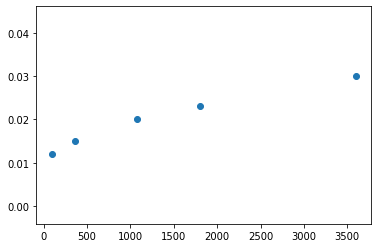

In [11]:
#=================== Aplico esta función al plazo que tengo para la curva =======================
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]
intervalo_curva=intervalo(plazo_curva)

print(plazo_curva,len(plazo_curva))

# ====================== Gráfico la curva con los valores iniciales ======================
tasas_curva=[0.012,0.015,0.02,0.023,0.03]
plt.scatter(plazo_curva[1:],tasas_curva)

In [12]:
# ========================== Veo como está el intervalo ===================================
intervalo_curva

array([[   0,   90],
       [  90,  360],
       [ 360, 1080],
       [1080, 1800],
       [1800, 3600]])

### Funciones para la creación de los plazos de la curva a la medidad del instrumento y el DF

In [13]:
def plazo_curva_fw(plazo_instrumento, plazos_curva):
    #plazo_instrumento: plazo de vencicimiento del instrumento
    #plazo_curva: plazos de la curva forward
    
    # Con esta fórmula construyo la base de plazos, teniendo en cuenta la duración del instrumento
    # lo que intento hacer es encontrar el mínimo entre los plazos
    # de esta manera si el venciemiento es menor al plazo tomo como referencia el plazo
    nuevos_plazos=[]
    for plazo in plazos_curva:
        nuevos_plazos=np.append(nuevos_plazos,min(plazo,plazo_instrumento))
    
    return intervalo(nuevos_plazos)
    
def DF(tasas_forwards, plazos):
    #tasa_forwards: tasas de la curva
    #plazos: plazos de a los que quiero valorar cada instrumento
    #tipo: tipo de crédito swap o libor
    
    #=========== Esto solo sirve para libor ===============================
    
    #con esta fórmula encuentro el factor de descuente para cada fecha
    #el factor se inicia en cero porque es el tiempo t=1
    # la fórmila sirve tanto para sacar los factores de descuento de libor y swaps
    # deja como variables las tasas forwards
    factor_d=[]
   
    for i in range(len(tasas_forwards)):
        periodo=(plazos[i][1]-plazos[i][0])/dia_año
        if periodo==0:
            FD_1=1
            factor_d=np.append(factor_d,FD_1)
        else:
            FD_1=np.exp(-tasas_forwards[i]*(periodo))#FD_1=mt.exp(-tasas_forwards[i])
            factor_d=np.append(factor_d,FD_1)
                
    return factor_d

In [26]:
#verificar que hace formula
plazo_curva_fw(30*3,plazo_curva)

array([[ 0., 90.],
       [90., 90.],
       [90., 90.],
       [90., 90.],
       [90., 90.]])

In [15]:
años=7
2*(años*360/360)

14.0

In [29]:
#verificar que hace la formula de los factores
DF(tasas_curva,plazo_curva_fw(30*3,plazo_curva))

IndexError: index 4 is out of bounds for axis 0 with size 4

# Fórmulas de valoración

In [77]:
def libor(tasa,tipo_libor,tasas_curva):
    # Con esta formula puedo saber cuanto se debe pagar al final del periodo con un crédito Libor
    #tasa: tasa libor para el periodo t
    # tipo libor: tipo de contrato
    # plazo curva: plazos de las curva forward
    global plazo_curva
    tipo=tipo_libor
    plazo_dias=plazos[tipo]
    vf_libor=100*(1+tasa*(plazo_dias/360))
    fechas=plazo_curva_fw(plazo_dias,plazo_curva)
    vp_libor=vf_libor*DF(tasas_curva,fechas).prod()
    return vp_libor

def fd_swaps(plazo_vencimiento,tasas_curva):
    # plazo vencimiento: plazo en el que vence el contrato 
    # con esta fórmula puedo sacar el valor presente de un crédito libor o un crédito diferente
    # para cada factor de descuento
    global plazo_curva
    factor=0
    factor_final=0
    for i in range(int(plazo_vencimiento/360)*2):
        fd=DF(tasas_curva,plazo_curva_fw((i+1)*6*30,plazo_curva)).prod()
        factor+=fd
        factor_final=fd
    return factor,factor_final

def swap(cupon,tipo_swap,tasas_curva):
    # cupon: valor en % del cupon. Dejarlo expresado en decimales
    # Tipo de swap es el nombre del swap segun bloomberg
    tipo=tipo_swap
    plazo_dias=plazos[tipo]
    fd=fd_swaps(plazo_dias,tasas_curva)
    vp_swap=100*(1/2)*cupon*fd[0]+100*fd[1]
    return vp_swap

In [78]:
tasas_curva=[0.015,0.015,0.02,0.023,0.03]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

fd_swaps(2*360,tasas_curva)

(3.9185553227081, 0.9656054162575665)

In [79]:
instrumento=4
swap(datos.iloc[500][instrumento],nombre[instrumento],tasas_curva)

99.35191346096408

In [80]:
nombre[0]

'ICE LIBOR USD 3 Month'

In [81]:
instrumento=0
libor(datos.iloc[1][1],nombre[0],[0.015,0.018,0.02,0.023,0.03])
#libor(datos.iloc[0][datos.columns[columna]],datos.columns[columna],tasas_curva)[0]

100.09861300227043

In [82]:
#verificar que hace la formula de los factores
DF([0.015,0.018,0.02,0.023,0.03],plazo_curva_fw(30*3,plazo_curva)).prod()

0.996257022469171

In [83]:
instrumento=0
libor(datos.iloc[1][1],nombre[0],[0.015,0.015,0.02,0.023,0.03])
#libor(datos.iloc[0][datos.columns[columna]],datos.columns[columna],tasas_curva)[0]

100.09861300227043

In [84]:
DF([0.015,0.015,0.02,0.023,0.03],plazo_curva_fw(30*3,plazo_curva)).prod()

0.996257022469171

In [85]:
np.array(datos.iloc[0])

array([0.0172152, 0.0188769, 0.0217313, 0.021946 , 0.022975 , 0.023949 ,
       0.024604 , 0.025405 ])

# Metodo de calibración

### Función de evaluación 

In [86]:
def error_cuadrado(tasas_curva,datos):
    # función a optimizar
    # tasa_curva: son las tasas que se quieren encontrar
    # datos es el dato para una fecha específica
    global plazo_curva
    global tipo
    error_cuadrado=0
    for instrumento in range(len(datos)):
        if tipo[instrumento]=="libor":
            error=100-libor(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado+=error**2
        else:
            error=100-swap(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado+=error**2
    return error_cuadrado

### Optimizador

In [87]:
tasas_iniciales=[0.015,0.015,0.02,0.023,0.03]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

def optimizador(datos,error_cuadrado):
    global plazo_curva
    global tasas_iniciales
    # Encuentre el mínimo error posible, bajo las tasas de la cuerva forward
    result=spo.minimize(error_cuadrado,tasas_iniciales,args=(datos,),method="SLSQP",options={"disp":True})
    return result

In [88]:
datos.iloc[-1:]

,ICE LIBOR USD 3 Month,ICE LIBOR USD 6 Month,ICE LIBOR USD 12 Month,USD SWAP SEMI 30/360 2YR,USD SWAP SEMI 30/360 3YR,USD SWAP SEMI 30/360 5YR,USD SWAP SEMI 30/360 7YR,USD SWAP SEMI 30/360 10Y
Dates,,,,,,,,
2020-02-12,0.017037,0.017254,0.018127,0.01489,0.014509,0.014585,0.015051,0.015894


In [89]:
#================ Prueba del optimizador =====================================
result=optimizador(datos.loc["2020-02-12"],error_cuadrado)
result.x

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial)
C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\mariaalejandra\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02985808103661735
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9


array([0.01678178, 0.01789624, 0.01267437, 0.01443775, 0.01728471])

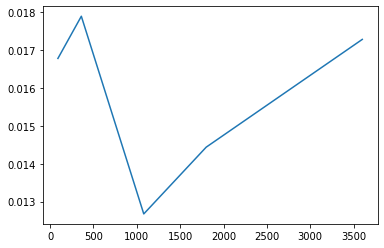

In [90]:
plt.plot(plazo_curva[1:],result.x)

In [91]:
tasa_fwrd=[]
for fecha in datos.index:
    tasa_fwrd=np.append(optimizador(datos.loc[fecha],error_cuadrado).x,tasa_fwrd)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.022161976999566575
            Iterations: 9
            Function evaluations: 90
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.017916013081479207
            Iterations: 9
            Function evaluations: 91
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.020774026007640684
            Iterations: 9
            Function evaluations: 90
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.021023673021066842
            Iterations: 10
            Function evaluations: 98
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.023825580689215368
            Iterations: 12
            Fun

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02673746820957719
            Iterations: 18
            Function evaluations: 161
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.027147461345695314
            Iterations: 16
            Function evaluations: 143
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02633582350856466
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.026192791236943007
            Iterations: 14
            Function evaluations: 126
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.021965582498078742
            Iterations: 13
       

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.022946186986163828
            Iterations: 19
            Function evaluations: 167
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.022121748236540853
            Iterations: 26
            Function evaluations: 226
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 50000.01504419564
            Iterations: 54
            Function evaluations: 471
            Gradient evaluations: 54
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.027429582425925577
            Iterations: 36
            Function evaluations: 307
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.028969035103121456
            Iterations: 20
        

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.021584513898147528
            Iterations: 28
            Function evaluations: 252
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02476466023567586
            Iterations: 38
            Function evaluations: 341
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02366265838301211
            Iterations: 38
            Function evaluations: 341
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02220546174531615
            Iterations: 35
            Function evaluations: 316
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01945584124700529
            Iterations: 60
         

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015965332717330867
            Iterations: 43
            Function evaluations: 403
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.014732732921369089
            Iterations: 35
            Function evaluations: 325
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01676566894904842
            Iterations: 37
            Function evaluations: 350
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 70000.00000000001
            Iterations: 46
            Function evaluations: 423
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 80000.0
            Iterations: 37
            Function e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.011614373227576054
            Iterations: 41
            Function evaluations: 373
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010655895380035939
            Iterations: 44
            Function evaluations: 431
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009223655149264182
            Iterations: 64
            Function evaluations: 608
            Gradient evaluations: 64
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008667456871602603
            Iterations: 46
            Function evaluations: 443
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009544789051595117
            Iterations: 38
     

Iteration limit exceeded    (Exit mode 9)
            Current function value: nan
            Iterations: 101
            Function evaluations: 1485
            Gradient evaluations: 101
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008228201447546981
            Iterations: 42
            Function evaluations: 395
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008973765924391919
            Iterations: 47
            Function evaluations: 415
            Gradient evaluations: 47
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010078789119636871
            Iterations: 46
            Function evaluations: 440
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010958804143911966
            Iterations: 37
            Function evaluations

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007811876344213479
            Iterations: 43
            Function evaluations: 387
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00840940743949836
            Iterations: 49
            Function evaluations: 438
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008384997827053656
            Iterations: 52
            Function evaluations: 504
            Gradient evaluations: 52
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 521248627.21732634
            Iterations: 95
            Function evaluations: 1006
            Gradient evaluations: 95
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 80000.0
            Iterations: 45
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 80000.0
            Iterations: 66
            Function evaluations: 641
            Gradient evaluations: 66
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01850011521425012
            Iterations: 43
            Function evaluations: 416
            Gradient evaluations: 43
Iteration limit exceeded    (Exit mode 9)
            Current function value: nan
            Iterations: 101
            Function evaluations: 1433
            Gradient evaluations: 101
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.017987867911282228
            Iterations: 46
            Function evaluations: 433
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.019939396130851765
            Iterations: 58
            Function evaluations: 554
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.028465042368695445
            Iterations: 28
            Function evaluations: 254
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.025393543181693113
            Iterations: 32
            Function evaluations: 271
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.022862122837390513
            Iterations: 37
            Function evaluations: 325
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02292616712840222
            Iterations: 44
            Function evaluations: 401
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02490714669229967
            Iterations: 32
       

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.038262027733016804
            Iterations: 13
            Function evaluations: 118
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.036326244732008184
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.036183986285667914
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03583786433591844
            Iterations: 11
            Function evaluations: 105
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03463373296880358
            Iterations: 13
       

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.031004222825798223
            Iterations: 8
            Function evaluations: 84
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.030705025354998857
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.029779551180957656
            Iterations: 8
            Function evaluations: 84
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0325965107844822
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03138212316520271
            Iterations: 8
            Function 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04587211868340668
            Iterations: 9
            Function evaluations: 86
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04413317168541203
            Iterations: 9
            Function evaluations: 86
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.046737419910737904
            Iterations: 9
            Function evaluations: 86
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04641885247013162
            Iterations: 9
            Function evaluations: 86
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04517984865713052
            Iterations: 9
            Function e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.024848497372706276
            Iterations: 9
            Function evaluations: 86
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.030582904818288126
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03086660681283746
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02479405914046477
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02726621043567432
            Iterations: 9
            Function 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.034940322414013396
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0343259197380694
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.039309260603865685
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03758510342413859
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03943325710497845
            Iterations: 9
            Function e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03158229143046443
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.032683052255567654
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.030918312094128042
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03262322946247209
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.029352424788566457
            Iterations: 9
            Function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.034252812727589455
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.032245187768827156
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.034272754462829305
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03206054631134433
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.034209115652329355
            Iterations: 9
            Functio

In [102]:
tasa_fwrd[:5]

array([0.01678178, 0.01789624, 0.01267437, 0.01443775, 0.01728471])

In [103]:
x=np.array([np.array(tasa_fwrd[i:i+5]) for i in range(0,len(tasa_fwrd)-1,5)])

In [104]:
#tasas_forward_finales=pd.DataFrame(x,index=datos.index)
#tasas_forward_finales.to_csv("tasas_finales.csv")

In [105]:
tasas_forward_finales=pd.read_csv("tasas_finales.csv", index_col="Dates")

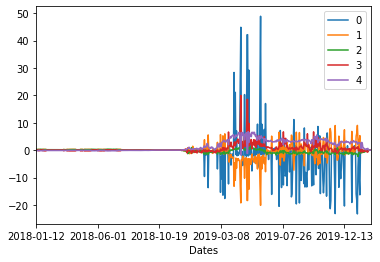

In [106]:
tasas_forward_finales.plot()

# Valoración prestamos

In [107]:
def fd_credito(plazo_vencimiento,tasas_curva):
    # plazo vencimiento: plazo en el que vence el contrato 
    # con esta fórmula puedo sacar el valor presente de un crédito libor o un crédito diferente
    # para cada factor de descuento
    global plazo_curva
    factor=0
    factor_final=0
    for i in range(int(plazo_vencimiento/360)):
        fd=DF(tasas_curva,plazo_curva_fw((i+1)*360,plazo_curva)).prod()
        factor+=fd
        factor_final=fd
    return factor,factor_final

def credito(cupon,plazo_año,tasas_curva,nocional):
    # cupon: valor en % del cupon. Dejarlo expresado en decimales. Usar fòrmula del cupon para saber su valor
    # plazo en años de la duraciòn del cupon
    # tasas_curva: tasas a las que se va a valorar el bono
    # valor de nocional en dòlares
    plazo_dias=plazo_año*360
    fd=fd_credito(plazo_dias,tasas_curva)
    vp_credito=nocional*cupon*fd[0]+nocional*fd[1]
    vf_credito=nocional*cupon/fd[0]+nocional/fd[1]
    return vp_credito,vf_credito

def cupon(plazo_año,tasas_curva):
    # plazo_años: plazo en años de la duraciòn del bono
    # tasas curva: tasa con las que se va a realizar la valoraciòn del bono
    plazo_dias=plazo_año*360
    fd=fd_credito(plazo_dias,tasas_curva)
    cupon=(1-fd[1])/fd[0]
    return cupon

In [108]:
tasa_valoracion_bono=result.x
cupon=cupon(7,tasa_valoracion_bono)
credito(cupon,7,tasa_valoracion_bono,50000000)

(50000000.0, 55729856.20643514)

# PCA de los factores

In [109]:
from sklearn.decomposition import PCA
import scipy.linalg as la

In [110]:
x=tasas_forward_finales-tasas_forward_finales.shift(1)
x=x.dropna()

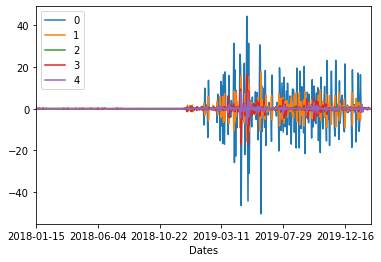

In [111]:
x.plot()

In [112]:
#x=x[-270:]
#x.iloc[0]

In [ ]:
import scipy.linalg as la
import math as mt

varcov = x.cov()
vals = pd.DataFrame(la.eig(varcov)[0])
SQRTvals= pd.DataFrame(vals.apply(mt.sqrt, axis= 1))
SQRTvals.sort_values(by=0, ascending=False).T
vecs = pd.DataFrame(la.eig(varcov)[1])
vecs[vals.sort_values(by=0, ascending=False).T.columns]

In [133]:
#12
N_PRIN_COMPONENTS = len(x.columns)
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(x)
percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print ('{0:.2f}% of the variance is explained by the first 1 PCs'.format(percentage_cum[0]*100))

95.21% of the variance is explained by the first 1 PCs


In [134]:
pca.components_[:]

array([[-0.93568894,  0.34270781, -0.01635755, -0.0708399 ,  0.04185339],
       [ 0.0567983 , -0.07928679,  0.04660426, -0.91525225,  0.38810941],
       [-0.31022019, -0.81713051,  0.4307819 ,  0.14592429,  0.17086314],
       [ 0.03214737,  0.0364352 , -0.36686988,  0.34579148,  0.86224925],
       [-0.15488751, -0.45523089, -0.82303944, -0.12817711, -0.27377254]])

In [153]:
varcov=x.cov()
varcov

,0,1,2,3,4
0,64.324474,-23.467529,1.086259,4.684405,-2.819187
1,-23.467529,8.881265,-0.542236,-1.587917,0.910078
2,1.086259,-0.542236,0.116783,-0.041703,0.005297
3,4.684405,-1.587917,-0.041703,3.091000,-1.323862
4,-2.819187,0.910078,0.005297,-1.323862,0.702127


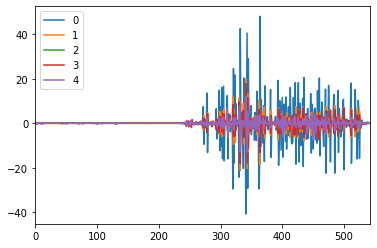

In [137]:
pd.DataFrame(np.dot(np.array(x),pca.components_[:])).plot()

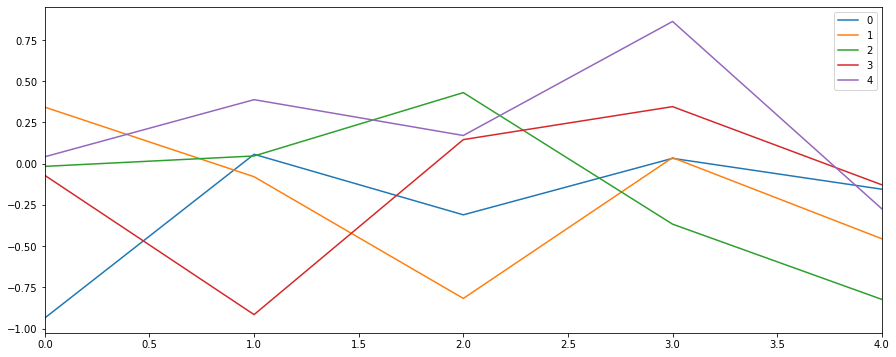

In [145]:
pd.DataFrame(pca.components_[:]).plot(figsize=(15,6))

In [154]:
vals=pd.DataFrame(la.eig(varcov)[0])

In [155]:
np.vals

,0
0,73.419493+0.000000j
1,3.226241+0.000000j
2,0.351050+0.000000j
3,0.016557+0.000000j
4,0.102308+0.000000j


In [168]:
vals.columns

RangeIndex(start=0, stop=5, step=1)

In [185]:
vals=pd.DataFrame(la.eig(varcov)[1])
#vals[["0","3","1","2","4"]]

In [166]:
pca.components_

array([[-0.93568894,  0.34270781, -0.01635755, -0.0708399 ,  0.04185339],
       [ 0.0567983 , -0.07928679,  0.04660426, -0.91525225,  0.38810941],
       [-0.31022019, -0.81713051,  0.4307819 ,  0.14592429,  0.17086314],
       [ 0.03214737,  0.0364352 , -0.36686988,  0.34579148,  0.86224925],
       [-0.15488751, -0.45523089, -0.82303944, -0.12817711, -0.27377254]])

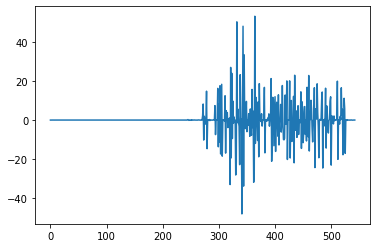

In [169]:
plt.plot(np.dot(x,pca.components_[0]))

componente_1=np.dot(x,pca.components_[0])

In [182]:
componente_1.shape

(543,)

# Arima

In [173]:
from pmdarima.arima import auto_arima
df_sarima=componente_1
step_wise=auto_arima(df_sarima, start_p=0, start_q=0, max_p=3, max_d=2, 
 max_q=12, d=0,seasonal=False, 
trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True )

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=3623.391, BIC=3640.579, Fit time=0.400 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=3876.797, BIC=3885.391, Fit time=0.039 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=3782.815, BIC=3795.706, Fit time=0.212 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=3635.113, BIC=3648.004, Fit time=0.264 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=3874.797, BIC=3879.094, Fit time=0.016 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=3625.207, BIC=3646.693, Fit time=0.577 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 0); AIC=3625.259, BIC=3646.745, Fit time=0.590 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 0); AIC=3623.387, BIC=3640.575, Fit time=0.421 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 0); AIC=3627.208, BIC=3652.991, Fit time=1.348 seconds
Fit ARIMA: order=(0, 0, 3) seasonal_o

In [184]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(endog=df_sarima,order=(0,0,2),enforce_invertibility=False)
results=model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  543
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1807.709
Date:                Sun, 23 Feb 2020   AIC                           3621.419
Time:                        19:59:35   BIC                           3634.310
Sample:                             0   HQIC                          3626.459
                                - 543                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7695      0.019    -41.069      0.000      -0.806      -0.733
ma.L2         -0.1565      0.020     -7.890      0.000      -0.195      -0.118
sigma2        45.4663      1.191     38.169      0.0

In [ ]:
import numpy as np
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 250)
model = sm.tsa.ARMA(y, (2, 2)).fit(trend='nc', disp=0)
model.params
array([ 0.79044189, -0.23140636,  0.70072904,  0.40608028])